# Template Pipeline
Normalisation&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;
**X -> Gaussian**  
Imputation 1&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;
**Median**  
Outlier Detection&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;
**Z Score**  
Imputation 2&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;
**Median**  
Feature Selection&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;
**Implicit to model**  
Model&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;
**Gaussian Process Regression**


## Imports

In [15]:
# General
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# ML
from sklearn.linear_model import LinearRegression, Lasso, LassoCV, BayesianRidge
from sklearn.metrics import r2_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.model_selection import cross_val_score
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import DotProduct, WhiteKernel

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from sklearn.model_selection import KFold
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
import sklearn
from tensorflow.keras import backend as K
from tensorflow.keras import regularizers
# Custom
import sys,os
sys.path.append('/home/jovyan/work/AML/Task_1/Solution') # I would like a cleaner solution but works for now
import Components.Imputation as Imputation
import Components.Outlier_Detection_1D as Outlier_Detection_1D
import Components.Outlier_Detection_ND as Outlier_Detection_ND
import Components.Feature_Selection as Feature_Selection
import Components.Normalisation as Normalisation
import Components.data_fetching as data_fetching
import Components.data_observations as data_observations

# CAREFUL:
# If you make changes to a custom module, you have to reload it, i.e rerun this cell
import importlib
importlib.reload(Imputation)
importlib.reload(Outlier_Detection_1D)
importlib.reload(Outlier_Detection_ND)
importlib.reload(Feature_Selection)
importlib.reload(Normalisation)
importlib.reload(data_fetching)
importlib.reload(data_observations)

<module 'Components.data_observations' from '/home/jovyan/work/AML/Task_1/Solution/Components/data_observations.py'>

## Data Cleaning

In [16]:
verbose = True
X, y = data_fetching.get_train_data()

missing_vals_mask = Imputation.missing_values_mask(X)
X = Imputation.median(X)
X,y, missing_vals_mask = Outlier_Detection_ND.mahalanobis_distance(X,y, missing_vals_mask, verbose=verbose)
X = Normalisation.gaussian(X)
X = Outlier_Detection_1D.z_score(X, verbose)
X = X.mask(missing_vals_mask) # Re-impute the ones we imputed before
X = Imputation.mean(X)

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=0)

# Outliers:  (array([ 106,  732,  948, 1057, 1102]),)
/home/jovyan/work/AML/Task_1/Solution/Components/Outlier_Detection_ND.py:34: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if mask == '':
# Outliers:  1287


## Model Training

### Simple

In [19]:
# train autoencoder on feature extraction
# This is the size of our encoded representations
encoding_dim = 64 

# This is our input image
input_data = keras.Input(shape=(832,))
# "encoded" is the encoded representation of the input
encoded = layers.Dense(encoding_dim, activation='relu')(input_data)
# "decoded" is the lossy reconstruction of the input
decoded = layers.Dense(832)(encoded)

# This model maps an input to its reconstruction
autoencoder = keras.Model(input_data, decoded)

# This model maps an input to its encoded representation
encoder = keras.Model(input_data, encoded)

# This is our encoded (32-dimensional) input
encoded_input = keras.Input(shape=(encoding_dim,))
# Retrieve the last layer of the autoencoder model
decoder_layer = autoencoder.layers[-1]
# Create the decoder model
decoder = keras.Model(encoded_input, decoder_layer(encoded_input))
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

autoencoder.fit(x_train, x_train,
                epochs=100,
                batch_size=25,
                shuffle=True,
                validation_data=(x_test, x_test))

Epoch 1/100
41/41 [==============================] - 1s 21ms/step - loss: -0.4363 - val_loss: -0.8129
Epoch 2/100
41/41 [==============================] - 1s 15ms/step - loss: -0.9351 - val_loss: -1.0897
Epoch 3/100
41/41 [==============================] - 0s 6ms/step - loss: -1.1635 - val_loss: -1.2330
Epoch 4/100
41/41 [==============================] - 0s 6ms/step - loss: -1.2733 - val_loss: -1.2575
Epoch 5/100
41/41 [==============================] - 0s 9ms/step - loss: -1.3222 - val_loss: -1.2932
Epoch 6/100
41/41 [==============================] - 0s 7ms/step - loss: -1.3357 - val_loss: -1.3719
Epoch 7/100
41/41 [==============================] - 0s 7ms/step - loss: -1.4228 - val_loss: -1.4286
Epoch 8/100
41/41 [==============================] - 1s 12ms/step - loss: -1.4569 - val_loss: -1.4154
Epoch 9/100
41/41 [==============================] - 0s 11ms/step - loss: -1.4701 - val_loss: -1.4519
Epoch 10/100
41/41 [==============================] - 0s 10ms/step - loss: -1.4885 - va

In [20]:
# Encode and decode some digits
# Note that we take them from the *test* set
encoded_imgs = encoder.predict(x_test)
decoded_imgs = decoder.predict(encoded_imgs)

print(x_test.iloc[0])
print(decoded_imgs[0])

0     -0.003753
1      0.148505
2     -0.010516
3     -1.398066
4      1.213541
         ...   
827   -0.799119
828    0.702441
829   -1.218201
830    1.041559
831    1.011401
Name: 592, Length: 832, dtype: float64
[-1.0812899e+00  3.4063308e+00 -2.1137152e+00 -1.2002540e+00
 -2.0257561e+00 -2.1880465e+00 -3.0988727e+00 -1.1531854e+00
 -2.5252037e+00 -2.8528113e+00 -1.1736176e+00 -5.3057182e-01
 -1.8274899e+00  8.7213475e-01 -1.6551738e+00 -3.0020907e+00
 -2.7399020e+00 -3.0819933e+00 -1.8238168e+00 -3.0475321e+00
 -3.0171616e+00 -1.3504857e+00 -2.0294971e+00 -3.1816833e+00
 -2.1016157e+00 -1.2471387e+00  2.3639613e-01 -2.1077859e+00
 -8.5907257e-01 -2.4963195e+00 -1.7302306e+00 -1.4707985e+00
 -1.1578641e+00 -8.6836344e-01 -2.9406741e+00 -1.6444266e+00
 -2.5646470e+00 -1.3814029e+00 -3.4941497e+00 -2.9144051e+00
 -3.5290556e+00 -1.5222549e+00 -1.4562367e-01 -3.6108341e+00
 -2.4977670e+00 -4.7083211e-01 -2.1109221e+00 -1.3942765e+00
 -2.0383167e+00 -7.7865523e-01 -8.8248718e-01 -2.5507

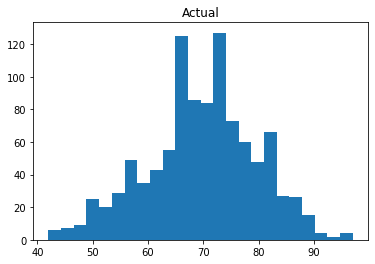

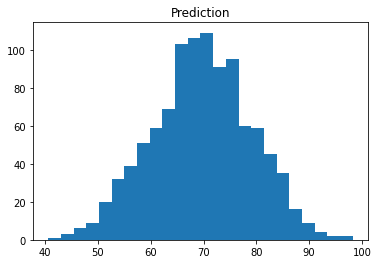

In [14]:
plt.hist(y_train.iloc[:,0].to_numpy(), bins='auto')
plt.title('Actual')
plt.show()

plt.hist(y_pred_train, bins='auto')
plt.title('Prediction')
plt.show()

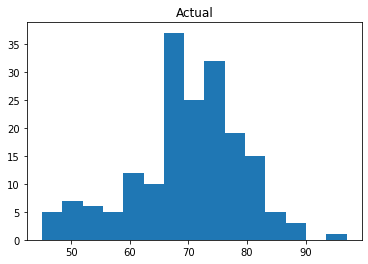

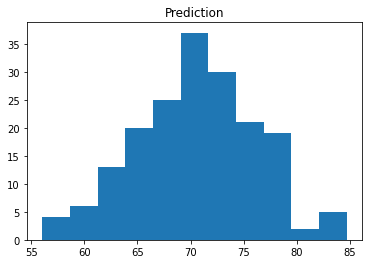

In [ ]:
plt.hist(y_test.iloc[:,0].to_numpy(), bins='auto')
plt.title('Actual')
plt.show()

plt.hist(y_pred_test, bins='auto')
plt.title('Prediction')
plt.show()

## Final Prediction

In [ ]:
# lasso_final = Lasso(normalize=False, max_iter=1000, alpha=0.35).fit(X, y)
lasso_final_cv = LassoCV(cv=5, random_state=0).fit(X, y)
x_test = data_fetching.get_test_data()

x_test = Imputation.mean(x_test)
x_test = Normalisation.gaussian(x_test)

# Note: They said no outliers were introduced in x_test so no need to perform outlier detection
y_pred = lasso_final_cv.predict(x_test)
plt.hist(y_pred)

y_pred_pd = pd.DataFrame(data=y_pred, columns=["y"])
print(y_pred_pd.head())
y_pred_pd.to_csv('../../Predictions/not_too_good_to_be_true.csv', index_label='id')

/opt/venv/lib/python3.7/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/opt/venv/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:527: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 18.57446441148568, tolerance: 9.374850155440416
  tol, rng, random, positive)
